## Cache

Julia is **column major**, meaning indexing by column is faster. Just like fortran. Python is row major

A[column, row]

In [40]:
using StaticArrays, BenchmarkTools, Plots, LinearAlgebra

In [2]:
A = rand(16,16)

function row_major_sum(A)
    sum = 0
    for i in 1:size(A)[1], j in 1:size(A)[1]
        sum = sum + A[i,j]
    end
    return sum
end

function column_major_sum(A)
    sum = 0
    for j in 1:size(A)[1], i in 1:size(A)[1]
        sum = sum + A[i,j]
    end
    return sum
end

column_major_sum (generic function with 1 method)

In [3]:
@btime row_major_sum(A)
@btime column_major_sum(A);

  347.335 ns (1 allocation: 16 bytes)
  276.959 ns (1 allocation: 16 bytes)


Column major is faster, this is because in memory, columns are stored adjacently in cache

## Stack and Heap

Stack - Stack requires static allocation and is ordered. Because it is ordered, we can access things very quick. But, since it's ordered it requires size of variables at compile time in order to allocate space. 

Heap - Since knowing how big things will be is not always possible, the heap exists for dynamic allocations. The heap is a stack of pointers to objects in memory. When heap variables are needed their values are pulled up to the cache and accessed. 

## Heap Allocations
Heap allocations are costly. Stack allocations should be used when sensible. 

In [4]:
A = rand(100,100)
B = rand(100,100)
C = zeros(100,100)

function stack_allocation(A,B)
    for j in 1:100, i in 1:100
        #here julia allocates val to the stack because it is a scalar. It can guarntee
        #that we will always have a certain amount of space used in it. 
        val = A[i,j] + B[i,j]
        C[i,j] = val[1]
    end
    return C
end

function heap_allocation(A,B)
    for j in 1:100, i in 1:100
        #by making val an array, julia allocates to heap. we don't know how big it will get!
        val = [A[i,j] + B[i,j]]
        C[i,j] = val[1]
    end
    return C
end

heap_allocation (generic function with 1 method)

In [5]:
@btime stack_allocation(A,B);
@btime heap_allocation(A,B);

  292.387 μs (10000 allocations: 156.25 KiB)
  638.892 μs (20000 allocations: 1.07 MiB)


Julia has static vectors, which allow us to allocate arrays to the stack instead of heap!

In [6]:
using StaticArrays
function staticvector_allocation(A,B)
    for j in 1:100, i in 1:100
        #by making val an array, julia allocates to heap. we don't know how big it will get!
        val = @SVector [A[i,j] + B[i,j]]
        C[i,j] = val[1]
    end
    return C
end
@btime staticvector_allocation(A,B);

  290.719 μs (10000 allocations: 156.25 KiB)


Not quite as fast as a scalar! But huge improvement, from a heap vector. What if we allocate matrices to the stack as well?

In [7]:
A_static = @SMatrix rand(16,16)
B_static = @SMatrix rand(16,16)
C_static = @MMatrix zeros(16,16)

A = rand(16,16)
B = rand(16,16)
C = zeros(16,16)


function stack_allocation!(C,A,B)
    for j in 1:16, i in 1:16
        val = A[i,j] + B[i,j]
        C[i,j] = val[1]
    end
    return C
end

@btime stack_allocation!(C_static, A_static, B_static);
@btime stack_allocation!(C,A,B);

  261.724 ns (0 allocations: 0 bytes)
  225.205 ns (0 allocations: 0 bytes)


In [8]:
@btime A_static * B_static;

  760.613 ns (1 allocation: 2.06 KiB)


In [9]:
@btime A*B;

  896.317 ns (1 allocation: 2.13 KiB)


In [10]:
@btime stack_allocation!(C_static, A_static, B_static);

  260.612 ns (0 allocations: 0 bytes)


Turns out @MMatrix is still heap allocated. But its faster for multiplication, not the example above?
I'm not sure why

## Julia Broadcasting
We can use array vectorization to avoid writing loops

The following two statements are equivalent

In [11]:
A = rand(16,16)
B = rand(16,16)
#statement 1:
C = A .+ B #element wise addition!

D = zeros(16,16)
#statement 2:
for j in 1:16, i in 1:16
    D[i,j] = A[i,j] + B[i,j]
end

C==D

true

But looping is the same speed, looping is not slow in julia, c++, and fortran. In python broadcasting is reccomended

In [12]:
function unfused(A,B,C)
  tmp = A .+ B
  C .+ tmp
end
w = @btime unfused(A,B,C);

  842.607 ns (2 allocations: 4.25 KiB)


In [13]:
fused(A,B,D) = A .+ B .+ C
w2 = @btime fused(A,B,C);


  804.188 ns (5 allocations: 2.22 KiB)


## Heap allocations from slicing
Outputting a slice, allocates this into the heap.
We can @view, to allocate only a pointer which will be very small.

In [14]:
A = rand(100,100);

In [15]:
@btime @view A[50,50]

  25.970 ns (1 allocation: 48 bytes)


0-dimensional view(::Array{Float64,2}, 50, 50) with eltype Float64:
0.7649130463502658

In [16]:
 @show A[50,50]

A[50, 50] = 0.7649130463502658


0.7649130463502658

## Asymtopic Cost of Heap Allocations

Heap allocations have to locate and prepare a space in RAM, the cost of an array is O(n). As ram fills up, the cost dramatically increases. If you run out of ram, your computer will start to use swap, which is essentially RAM simulated on your hard drive. Swap is incredibly slow.

Heap allocations will dominate cost.

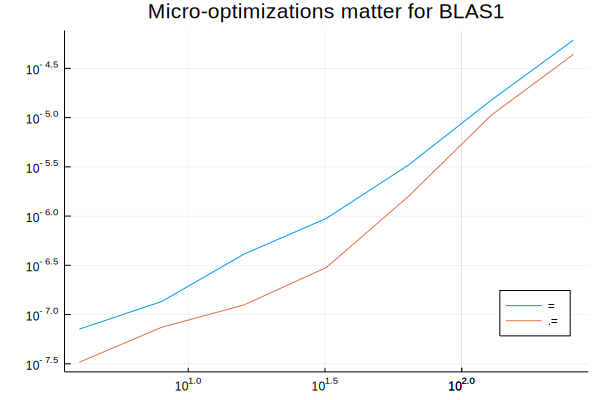

In [19]:
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    #belapsed returns the time it took to run the calculation.
    #$ is for variables that depend on external variables. A depends on n
    # so this will avoid counting the n time when doing this calculation.
    t1 = @belapsed $A .* $B
    t2 = @belapsed ($C .= $A .* $B)
    t1,t2
end
ns = 2 .^ (2:8)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

plot(ns,alloc,label="=",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations matter for BLAS1")
plot!(ns,noalloc,label=".=")

As shown in the above graph, .= is faster! Use it whenever possible. 

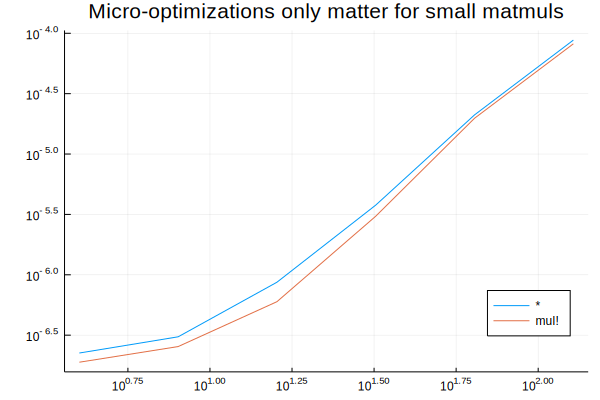

In [36]:
using LinearAlgebra, BenchmarkTools
function alloc_timer(n)
    A = rand(n,n)
    B = rand(n,n)
    C = rand(n,n)
    t1 = @belapsed $A*$B
    t2 = @belapsed mul!($C,$A,$B)
    t1,t2
end
ns = 2 .^ (2:7)
res = [alloc_timer(n) for n in ns]
alloc   = [x[1] for x in res]
noalloc = [x[2] for x in res]

using Plots
plot(ns,alloc,label="*",xscale=:log10,yscale=:log10,legend=:bottomright,
     title="Micro-optimizations only matter for small matmuls")
plot!(ns,noalloc,label="mul!")

mul! is faster!!!
# Optimizing memory use summary:
1. Avoid cache misses by reusing variables
2. Iterate along columns
3. Avoid heap allocations within inner loops
4. Heap allocations occur when the size cannot be proven at compile time (arrays)
5. Use fused broadcasts to avoid heap allocations
6. Use @view whenever necessary to avoid allocating
7. Use staticarrays.jl to avoid heap allocations of small arrays

# Julia's type inference and compiler
Julia is fast because of the two ideas:
1. Type inference
2. Specialization in functions

Everything has a type. One can't compute without a type because then the computer doesn't know the memory or how it's stored.
In C++, you declare types:

double *a

In interpreted languages like python, types are checked at runtime. We don't have to explicetly tell the compiler what it is

a = 2
b = 4 
a+b

When the add function is called in python, the interpreter much check the object holding the values of a and b and ask for the types. Thus the python add function is complicated because it needs a version to decode and have a version for all primitive types. Thus there is a runtime overhead checks in function calls due to not being explicit about types, but there is also memory overhead since it is impossible to know how much memory a value will take since that's a property of its type. Thus every variable ends up being heap-allocated

The julia solution is a hybrid of the two, the code looks the same as python. But before compilation, julia runs a type inference alogirthm which finds out that A and B are Ints. Then a+b should be an int. Sooo we can stack allocate things now.

# Type Specializations in Functions
Julia can propogate type inference through functions because even though functions are untypes, julia will interpet this as a generic functoin, over possible methods, where every method has a concrete type. You can see this in:

In [39]:
f(x,y) = x+y

f (generic function with 1 method)

In [42]:
using InteractiveUtils
#LLVM is julia's compiler
@code_llvm f(2,5)


;  @ In[39]:1 within `f'
define i64 @julia_f_20223(i64, i64) {
top:
; ┌ @ int.jl:53 within `+'
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [43]:
@code_llvm f(2.0,5.0)


;  @ In[39]:1 within `f'
define double @julia_f_20224(double, double) {
top:
; ┌ @ float.jl:401 within `+'
   %2 = fadd double %0, %1
; └
  ret double %2
}


In [45]:
function g(x,y)
  a = 4
  b = 2
  c = f(x,a)
  d = f(b,c)
  f(d,y)
end

@code_llvm g(2,5)
#g inputs two ints, and spits out ints from f as well! As expected


;  @ In[45]:2 within `g'
define i64 @julia_g_20226(i64, i64) {
top:
;  @ In[45]:5 within `g'
; ┌ @ In[39]:1 within `f'
; │┌ @ int.jl:53 within `+'
    %2 = add i64 %0, 6
; └└
;  @ In[45]:6 within `g'
; ┌ @ In[39]:1 within `f'
; │┌ @ int.jl:53 within `+'
    %3 = add i64 %2, %1
; └└
  ret i64 %3
}


In [47]:
#this behavior can be seen more clearly :
@code_warntype g(2,5)

Variables
  #self#::Core.Compiler.Const(g, false)
  x::Int64
  y::Int64
  a::Int64
  b::Int64
  c::Int64
  d::Int64

Body::Int64
1 ─      (a = 4)
│        (b = 2)
│        (c = Main.f(x, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %5 = Main.f(d, y)::Int64
└──      return %5


In [48]:
#what about a mixture? int + a double should be a double...
@code_llvm g(2.0,5)


;  @ In[45]:2 within `g'
define double @julia_g_20351(double, i64) {
top:
;  @ In[45]:4 within `g'
; ┌ @ In[39]:1 within `f'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %2 = fadd double %0, 4.000000e+00
; └└
;  @ In[45]:5 within `g'
; ┌ @ In[39]:1 within `f'
; │┌ @ promotion.jl:311 within `+' @ float.jl:401
    %3 = fadd double %2, 2.000000e+00
; └└
;  @ In[45]:6 within `g'
; ┌ @ In[39]:1 within `f'
; │┌ @ promotion.jl:311 within `+'
; ││┌ @ promotion.jl:282 within `promote'
; │││┌ @ promotion.jl:259 within `_promote'
; ││││┌ @ number.jl:7 within `convert'
; │││││┌ @ float.jl:60 within `Float64'
        %4 = sitofp i64 %1 to double
; ││└└└└
; ││ @ promotion.jl:311 within `+' @ float.jl:401
    %5 = fadd double %3, %4
; └└
  ret double %5
}


# Multiple Dispactch:
In julia you can tell a function how to act based on what types are inputted to it. 

In [50]:
ff(x::Int, y::Int) = x+y
ff(x::Float64, y::Float64) = "FLOATS!!!!"

ff (generic function with 2 methods)

In [51]:
ff(2,3)

5

In [52]:
ff(2.0,3.0)

"FLOATS!!!!"

In [53]:
@which +(2.0,5)

+(x::Number, y::Number) in Base at promotion.jl:311

In [54]:
+(3,4)

7

In [3]:
f(x,y) = x+y
#is equivalent to
g(x::Any, y::Any) = x+y
#where ::Any is the maximal subtype in Julia

g (generic function with 1 method)

In [7]:
@code_llvm g(3,4)


;  @ In[3]:3 within `g'
define i64 @julia_g_17518(i64, i64) {
top:
; ┌ @ int.jl:53 within `+'
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


In [5]:
@code_llvm f(3,4)


;  @ In[3]:1 within `f'
define i64 @julia_f_17467(i64, i64) {
top:
; ┌ @ int.jl:53 within `+'
   %2 = add i64 %1, %0
; └
  ret i64 %2
}


# Untyped Containers
- One way to ruin inference is to use an untyped container. For example, array constructors use type inference themselves to know what their container type will be...

In [9]:
a = [1.0,2.0,3.0]
#used type inferecne to see that we are inputting Float64s, so now its' a float64 contiainer.

3-element Array{Float64,1}:
 1.0
 2.0
 3.0

In [15]:
append!(a,4)
#even if we add an int...
typeof(a[4])

Float64

a[1] is just the function, getindex(a::Array{T}, i) where T is a function that will produce something of type T. We can also make an any type array.

In [17]:
b = [3.0, 4, "5.0"]

3-element Array{Any,1}:
 3.0   
 4     
  "5.0"

In [20]:
function bad_container(a)
  a[2]
end
@code_warntype bad_container(b)
#thus inference is broken! We can even break it with all numbers...

Variables
  #self#::Core.Compiler.Const(bad_container, false)
  a::Array{Any,1}

Body::Any
1 ─ %1 = Base.getindex(a, 2)::Any
└──      return %1


In [25]:
x = Number[1.0,3]
function q(x)
  a = 4
  b = 2
  c = f(x[1],a)
  d = f(b,c)
  f(d,x[2])
end
@code_warntype q(x)
#inference is broken again... We have any variables. Thus when the inference is broken, 
#we switch to pythonstyle runtime checking which is SLOWWW

Variables
  #self#::Core.Compiler.Const(q, false)
  x::Array{Number,1}
  a::Int64
  b::Int64
  c::Any
  d::Any

Body::Any
1 ─      (a = 4)
│        (b = 2)
│   %3 = Base.getindex(x, 1)::Number
│        (c = Main.f(%3, a::Core.Compiler.Const(4, false)))
│        (d = Main.f(b::Core.Compiler.Const(2, false), c))
│   %6 = d::Any
│   %7 = Base.getindex(x, 2)::Number
│   %8 = Main.f(%6, %7)::Any
└──      return %8


# Type Definitions
In Julia, types which can fully inferred and which are composed of primitive or isbits types are value types. This means that, inside an array, their values are the values of the type itself, and not a pointer to the values.

In [26]:
isbits(1.0)

true

A struct, that holds isbits balues is isbits as well

In [27]:
struct MyComplex
  real::Float64
  imag::Float64
end
isbits(MyComplex(1.0,1.0))

true

We can see that the compiler knows how to use htis struct efficiently since it knows that what comes out will always be a Float64

In [35]:
Base.:+(a::MyComplex,b::MyComplex) = MyComplex(a.real+b.real,a.imag+b.imag)
Base.:+(a::MyComplex,b::Int) = MyComplex(a.real+b,a.imag)
Base.:+(b::Int,a::MyComplex) = MyComplex(a.real+b,a.imag)
g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))
@code_warntype g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))


Variables
  #self#::Core.Compiler.Const(g, false)
  x::MyComplex
  y::MyComplex

Body::MyComplex
1 ─ %1 = (x + y)::MyComplex
└──      return %1


In [36]:
@code_llvm g(MyComplex(1.0,1.0),MyComplex(1.0,1.0))




;  @ In[3]:3 within `g'
define void @julia_g_17932({ double, double }* noalias nocapture sret, { double, double } addrspace(11)* nocapture nonnull readonly dereferenceable(16), { double, double } addrspace(11)* nocapture nonnull readonly dereferenceable(16)) {
top:
; ┌ @ In[35]:1 within `+' @ float.jl:401
   %3 = bitcast { double, double } addrspace(11)* %1 to <2 x double> addrspace(11)*
   %4 = load <2 x double>, <2 x double> addrspace(11)* %3, align 8
   %5 = bitcast { double, double } addrspace(11)* %2 to <2 x double> addrspace(11)*
   %6 = load <2 x double>, <2 x double> addrspace(11)* %5, align 8
   %7 = fadd <2 x double> %4, %6
; └
  %8 = bitcast { double, double }* %0 to <2 x double>*
  store <2 x double> %7, <2 x double>* %8, align 8
  ret void
}


In [ ]:
struct MyParameterizedComplex{T}
  real::T
  imag::T
end
isbits(MyParameterizedComplex(1.0,1.0))

{T} is a concree type for every T, type. It is a shorthand form for defining a whole famiily of types.

# Function Barriers
Since functions automatically specialize on their input types in Julia, we can use this to our advantage in order to make an inner loop fully inferred. Example:

I don't understand this at all? Why is it faster...

In [42]:
#Here the loop variables are not inferred. 
function r(x)
  a = 4
  b = 2
  for i in 1:100
    c = f(x[1],a)
    d = f(b,c)
    a = f(d,x[2])
  end
  a
end
@btime r(x)

  6.701 μs (300 allocations: 4.69 KiB)


604.0

In [46]:
#Here we force a function call in the middle to end up with specialization and in the intner loop to be stable
s(x) = _s(x[1],x[2]) # how does this even work.
function _s(x1,x2)
  a = 4
  b = 2
  for i in 1:100
    c = f(x1,a)
    d = f(b,c)
    a = f(d,x2)
  end
  a
end
@btime s(x)

  300.880 ns (1 allocation: 16 bytes)


604.0